# Results

### Load required packages

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(tidymodels))
suppressMessages(library(pROC))

### Load Data

In [2]:
# setwd("/home/jacky/Project/DiseaseGenePipieline/MachineLearning_Ver6/00_Data")
# load("MachineLearning_Input.rda")

In [ ]:
# setwd("/home/jacky/Project/DiseaseGenePipieline/MachineLearning_Ver6/00_Data")
# snp_scoring_input <- fread("SnpPrioritization_Input.txt")
# snp_scoring_input <- as.data.frame(snp_scoring_input[, -c("CHR", "BP")]) %>% 
#                         drop_na() %>% distinct(SNP, .keep_all = TRUE)

In [ ]:
# table(duplicated(colnames(machine_learning_input)))
# table(duplicated(snp_scoring_input$SNP))

In [ ]:
# colnames(snp_scoring_input)

### Define functions

In [2]:
main2 <- function(main_snp_score_table, main_ml_table) {
    foom_selected_snp <- top.snp2(main_snp_score_table, main_ml_table)
    foom_selected_matrix <- main_ml_table[, c("default", foom_selected_snp)]
    return(mean.roc2(foom_selected_matrix))
    }


main2.onlyp <- function(foo1_p_matrix, main_ml_table) {
    foo1_p_matrix$P <- scale.pseudocount(-log10(foo1_p_matrix$P))
    snp_score <- foo1_p_matrix %>% select(SNP, P)
    # select top snps
    foo_snp_score_intersected <- snp_score[snp_score$SNP %chin% colnames(main_ml_table[,-1]),]
    foo1_selected_snp <- head(foo_snp_score_intersected[order(foo_snp_score_intersected$P, decreasing = TRUE),], n = (nrow(main_ml_table)%/%5)) %>% pull(SNP)
    foom_selected_matrix <- main_ml_table[, c("default", foo1_selected_snp)]
    return(mean.roc2(foom_selected_matrix))
    }



#scale between 0 and 100, add pseudocount
scale.pseudocount <- function(x) {   
    ((x - min(x))/(max(x) - min(x)))*100 + 1
    }


top.snp2 <- function(foo1_p_matrix, main_ml_table) {
    foo1_p_matrix$P <- scale.pseudocount(-log10(foo1_p_matrix$P))
    
    for(i in 3:ncol(foo1_p_matrix)) {
        foo1_p_matrix[,i] <- scale.pseudocount(foo1_p_matrix[,i])
    }

    foo1_p_matrix$Score <- apply(foo1_p_matrix[,2:ncol(foo1_p_matrix)], 1, prod)
    snp_score <- foo1_p_matrix %>% select(SNP, Score)

    # select top snps
    foo_snp_score_intersected <- snp_score[snp_score$SNP %chin% colnames(main_ml_table[,-1]),]
    foo1_selected_snp <- head(foo_snp_score_intersected[order(foo_snp_score_intersected$Score, decreasing = TRUE),], n = (nrow(machine_learning_input)%/%5)) %>% pull(SNP)
    return(foo1_selected_snp)
    }



# mean roc curve of 200 iteration
mean.roc2 <- function(foo_matrix2) {

    foo_lr_df <- data.frame(.pred_Yes = double(), default = factor(), replication = integer(), stringsAsFactors = FALSE)
    auc_list <- list()
    
    for (i in c(1:200)) {
        foo_split <- initial_split(foo_matrix2, prop = 0.7, strata = default)
        foo_train <- foo_split %>% training()
        foo_test <- foo_split %>% testing()
        
        foo_lr_fit <- logistic_reg(mixture = double(1), penalty = double(1)) %>% 
            set_engine("glmnet") %>% set_mode("classification") %>% 
            fit(default ~ ., data = foo_train)
        
        foo_lr_prediction <- as.data.frame(predict(foo_lr_fit, new_data = foo_test, type = "prob"))
        foo_lr_prediction$default <- foo_test$default
        foo_lr_prediction <- foo_lr_prediction %>% select(-".pred_No")

        auc_list <- c(auc_list, auc(roc(response = foo_lr_prediction$default, predictor = foo_lr_prediction$.pred_Yes, direction = "<", levels = c("No", "Yes"))))
        
        foo_lr_prediction$replication <- i
        foo_lr_df <- rbind(foo_lr_df, foo_lr_prediction)    
    }

    foo_mean_roc <- roc(response = foo_lr_df$default, predictor = foo_lr_df$.pred_Yes, direction = "<", levels = c("No", "Yes"))
    ci_roc_mean <- ci.se(foo_mean_roc, specificities=seq(0, 1, l=100))
    dat.ci <- data.frame(x = as.numeric(rownames(ci_roc_mean)),
                         lower = ci_roc_mean[, 1],
                         upper = ci_roc_mean[, 3])
    
    P <- ggroc(foo_mean_roc) + theme_classic() + geom_abline(slope=1, intercept = 1, linetype = "dashed", alpha=0.7, color = "grey", linewidth = 0.5) + coord_equal() + 
      geom_ribbon(data = dat.ci, aes(x = x, ymin = lower, ymax = upper), fill = "#faa307", alpha= 0.2)

    plot(P)
    cat("Mean AUROC:", mean(as.numeric(auc_list)), "\n", "AUROC of Plot:", auc(foo_mean_roc))

    return(list(foo_mean_roc, dat.ci))
    }

In [ ]:
# ### GWAS
# roc_ce_gwas_400kb <- main2.onlyp(snp_scoring_input[,c("SNP","P")], machine_learning_input)

In [ ]:
# ### Current Best Combination
# roc_ce_current <- main2(snp_scoring_input[,c("SNP","P","H3K27me3","H3K4me3","H3K36me3","placode_400kb","neural_crest_400kb")], machine_learning_input)

In [ ]:
# ### Worst Combination
# roc_ce_worst <- main2(snp_scoring_input[,c("SNP","P","H3K4me1","placode_400kb")], machine_learning_input)

In [ ]:
# setwd("/home/jacky/Project/DiseaseGenePipieline/MachineLearning_Ver6/00_Data")
# save(roc_ce_gwas_400kb, file = "ROC_Object_GWASOnly.rda")
# save(roc_ce_current, file = "ROC_Object_Best.rda")
# save(roc_ce_worst, file = "ROC_Oject_Worst.rda")

In [3]:
setwd("/home/jacky/Project/DiseaseGenePipieline/MachineLearning_Ver6/00_Data")
load("ROC_Object_GWASOnly.rda")
load("ROC_Object_Best.rda")
load("ROC_Oject_Worst.rda")

In [ ]:
# best + worst + none

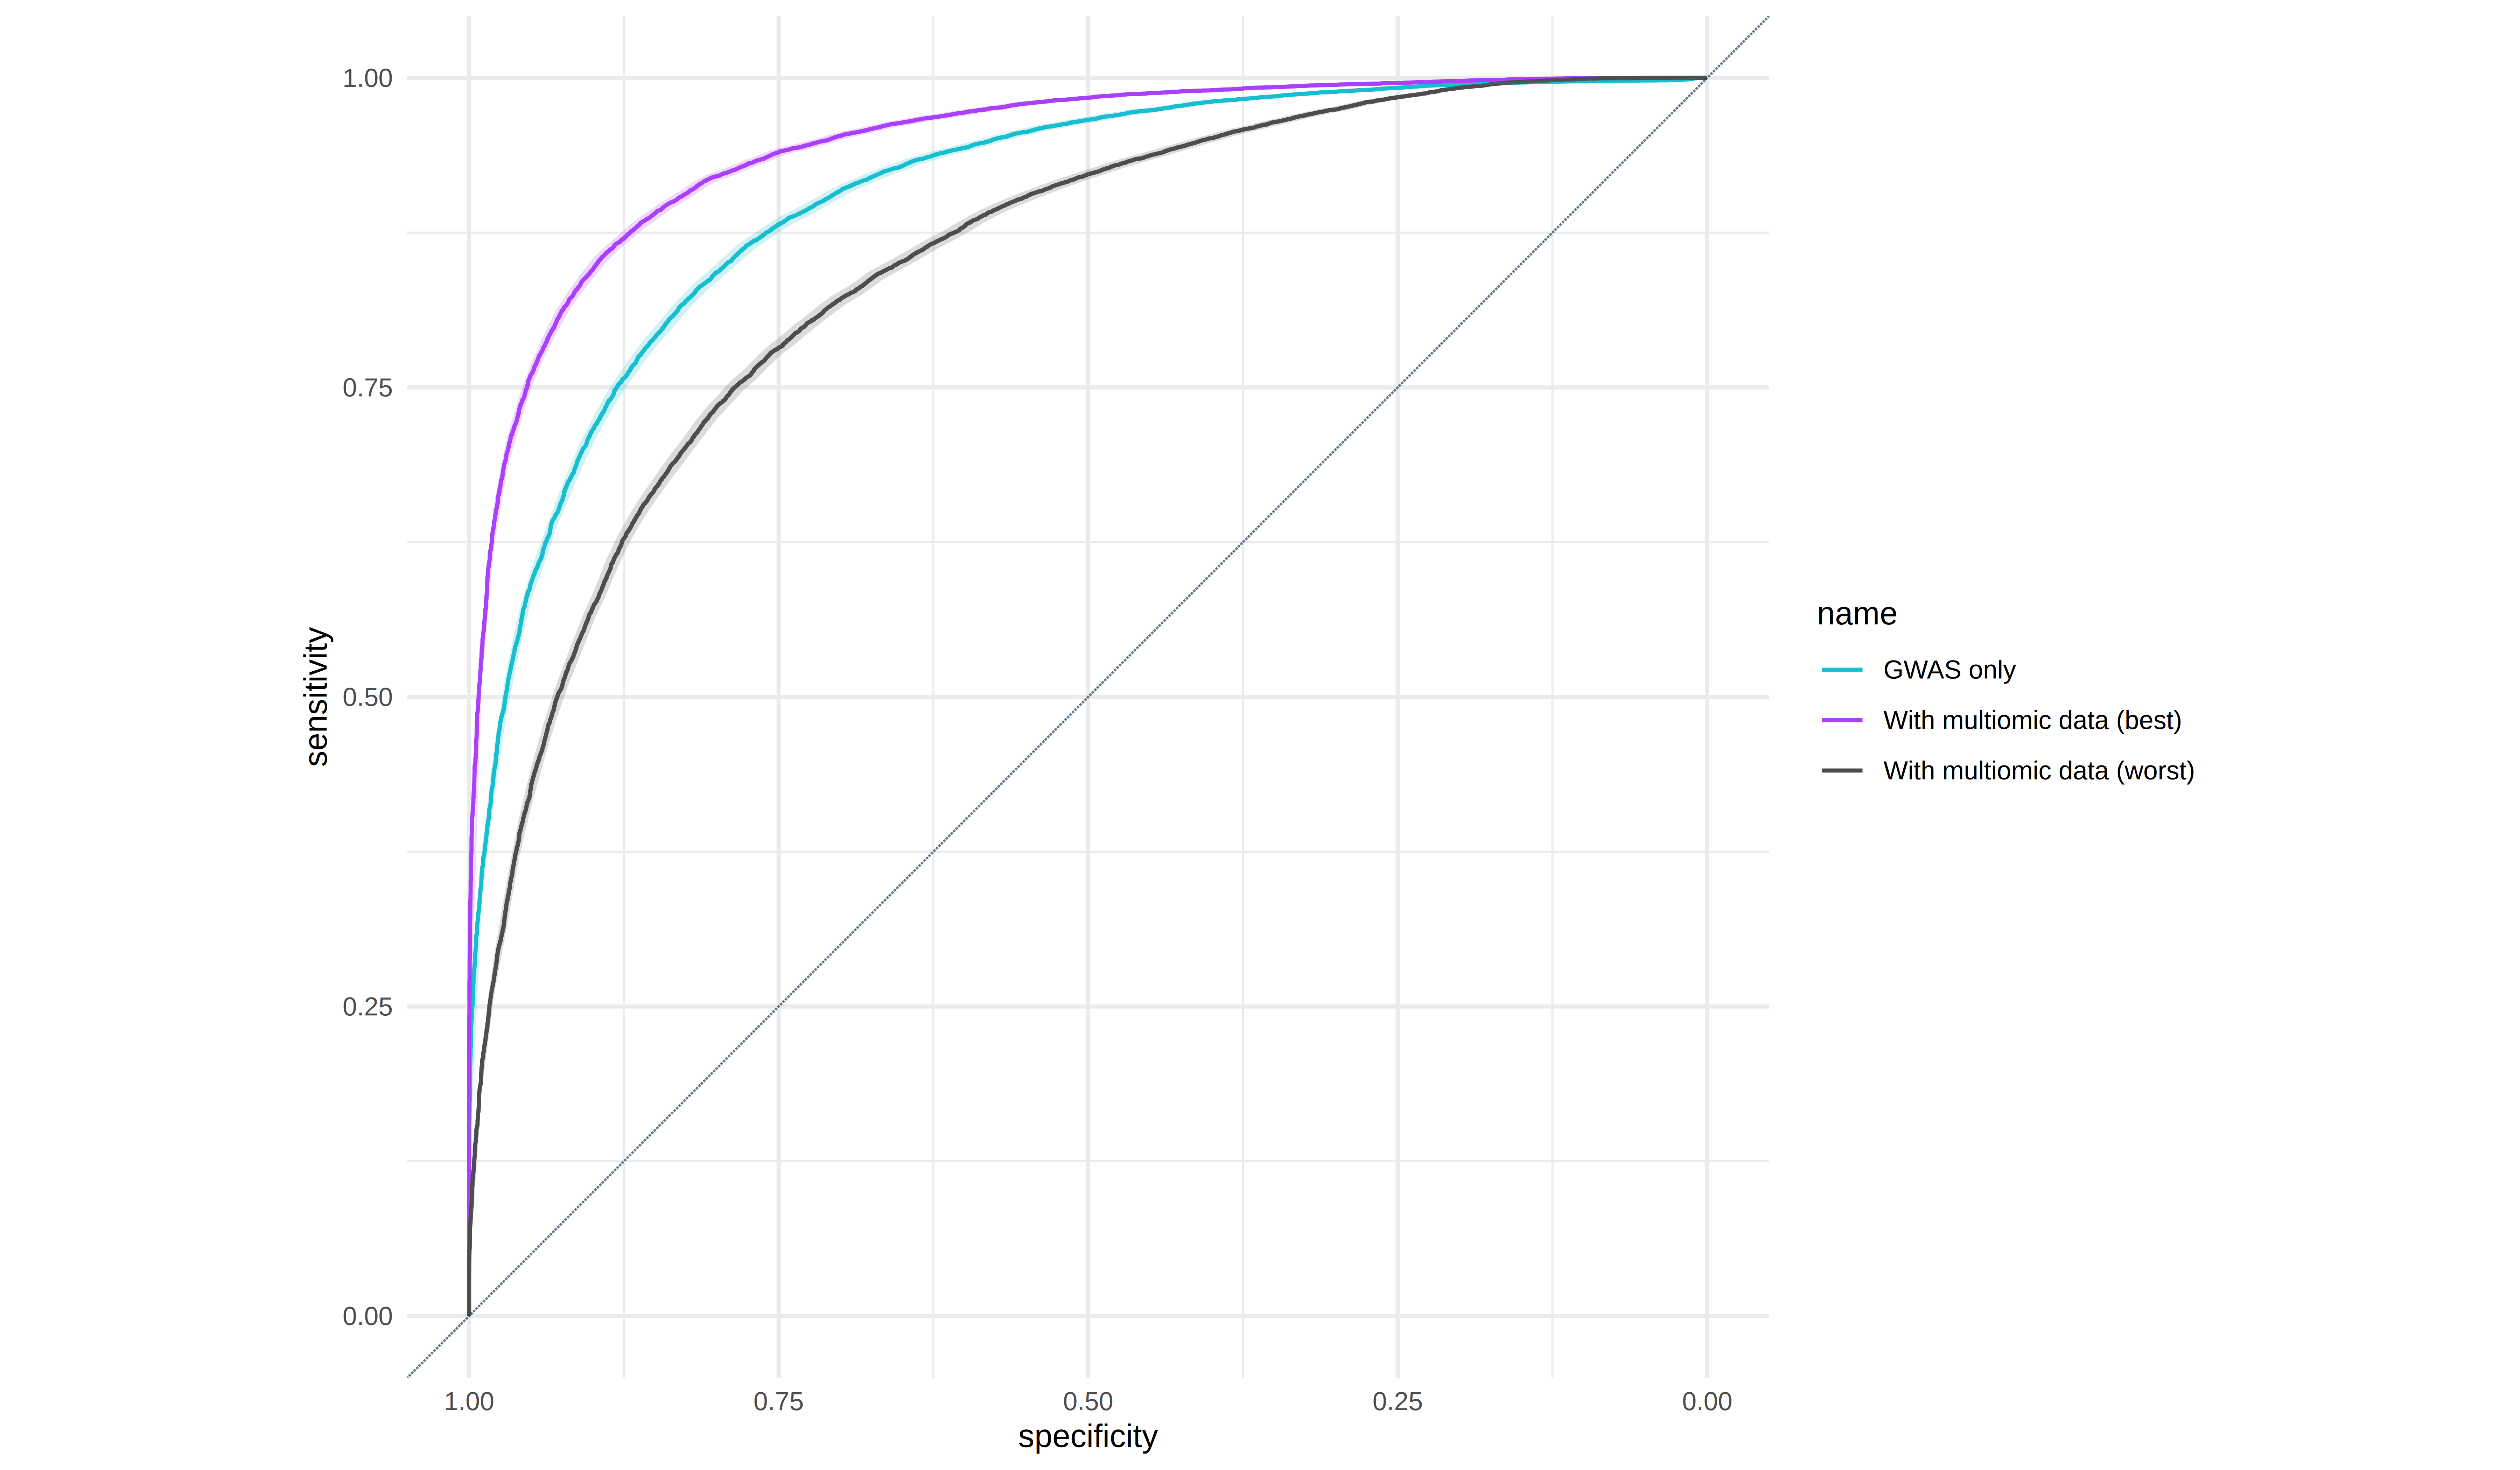

In [14]:
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 600)

p <- ggroc(list("GWAS only" = roc_ce_gwas_400kb[[1]], 
                "With multiomic data (best)" = roc_ce_current[[1]],
                "With multiomic data (worst)" = roc_ce_worst[[1]])) + 

    geom_abline(slope=1, intercept = 1, linetype = "longdash", color = "#2C3E50", alpha = 0.7, size = 0.3) + coord_equal() + 
    geom_ribbon(data = roc_ce_gwas_400kb[[2]], aes(x = x, ymin = lower, ymax = upper), fill = "#17BECF", alpha = 0.2, inherit.aes = F) +
    geom_ribbon(data = roc_ce_current[[2]], aes(x = x, ymin = lower, ymax = upper), fill = "#AA40FC", alpha = 0.2, inherit.aes = F) +
    geom_ribbon(data = roc_ce_worst[[2]], aes(x = x, ymin = lower, ymax = upper), fill = "grey30", alpha = 0.2, inherit.aes = F) +
    
    theme(axis.ticks.x = element_blank(), axis.ticks.y = element_blank()) +
    theme_minimal() + 
    scale_color_manual(values = c("#17BECF", "#AA40FC", "grey30"))

p

In [8]:
ranking <- fread("/home/jacky/Project/DiseaseGenePipieline/Manuscript/Figure2/AUC_AllCombination_Nonneural_Ecto_20250505.txt")

In [9]:
ranking

Combination,AUC,Group
<chr>,<dbl>,<chr>
GWAS&H3K27me3&H3K4me3&H3K36me3&placode_20241205&neural_crest_20241205,0.9487201,all
GWAS&H3K27me3&H3K36me3&epidermal_20241205,0.9473770,all
GWAS&non_neuroectoderm_20241205&epidermal_20241205&placode_20241205&neural_crest_20241205,0.9417167,all
GWAS&H3K4me3&H3K36me3&placode_20241205&neural_crest_20241205,0.9409278,all
GWAS&H3K4me2&H3K36me3&placode_20241205&neural_crest_20241205,0.9409139,all
GWAS&H3K36me3&epidermal_20241205,0.9404090,all
GWAS&H3K27me3&H3K4me1&H3K4me3&H3K36me3&neural_crest_20241205,0.9396105,all
GWAS&H3K36me3&epidermal_20241205&placode_20241205,0.9382093,all
GWAS&H3K4me1&H3K4me3&H3K36me3&neural_crest_20241205,0.9369735,all


In [10]:
ranking$Rank <- 1:nrow(ranking)

In [ ]:
ranking$fill_color <- ifelse(ranking$Rank == 2, "#3498DB",
                      ifelse(ranking$Rank == 4, "#E74C3C", "#E8E8E8"))

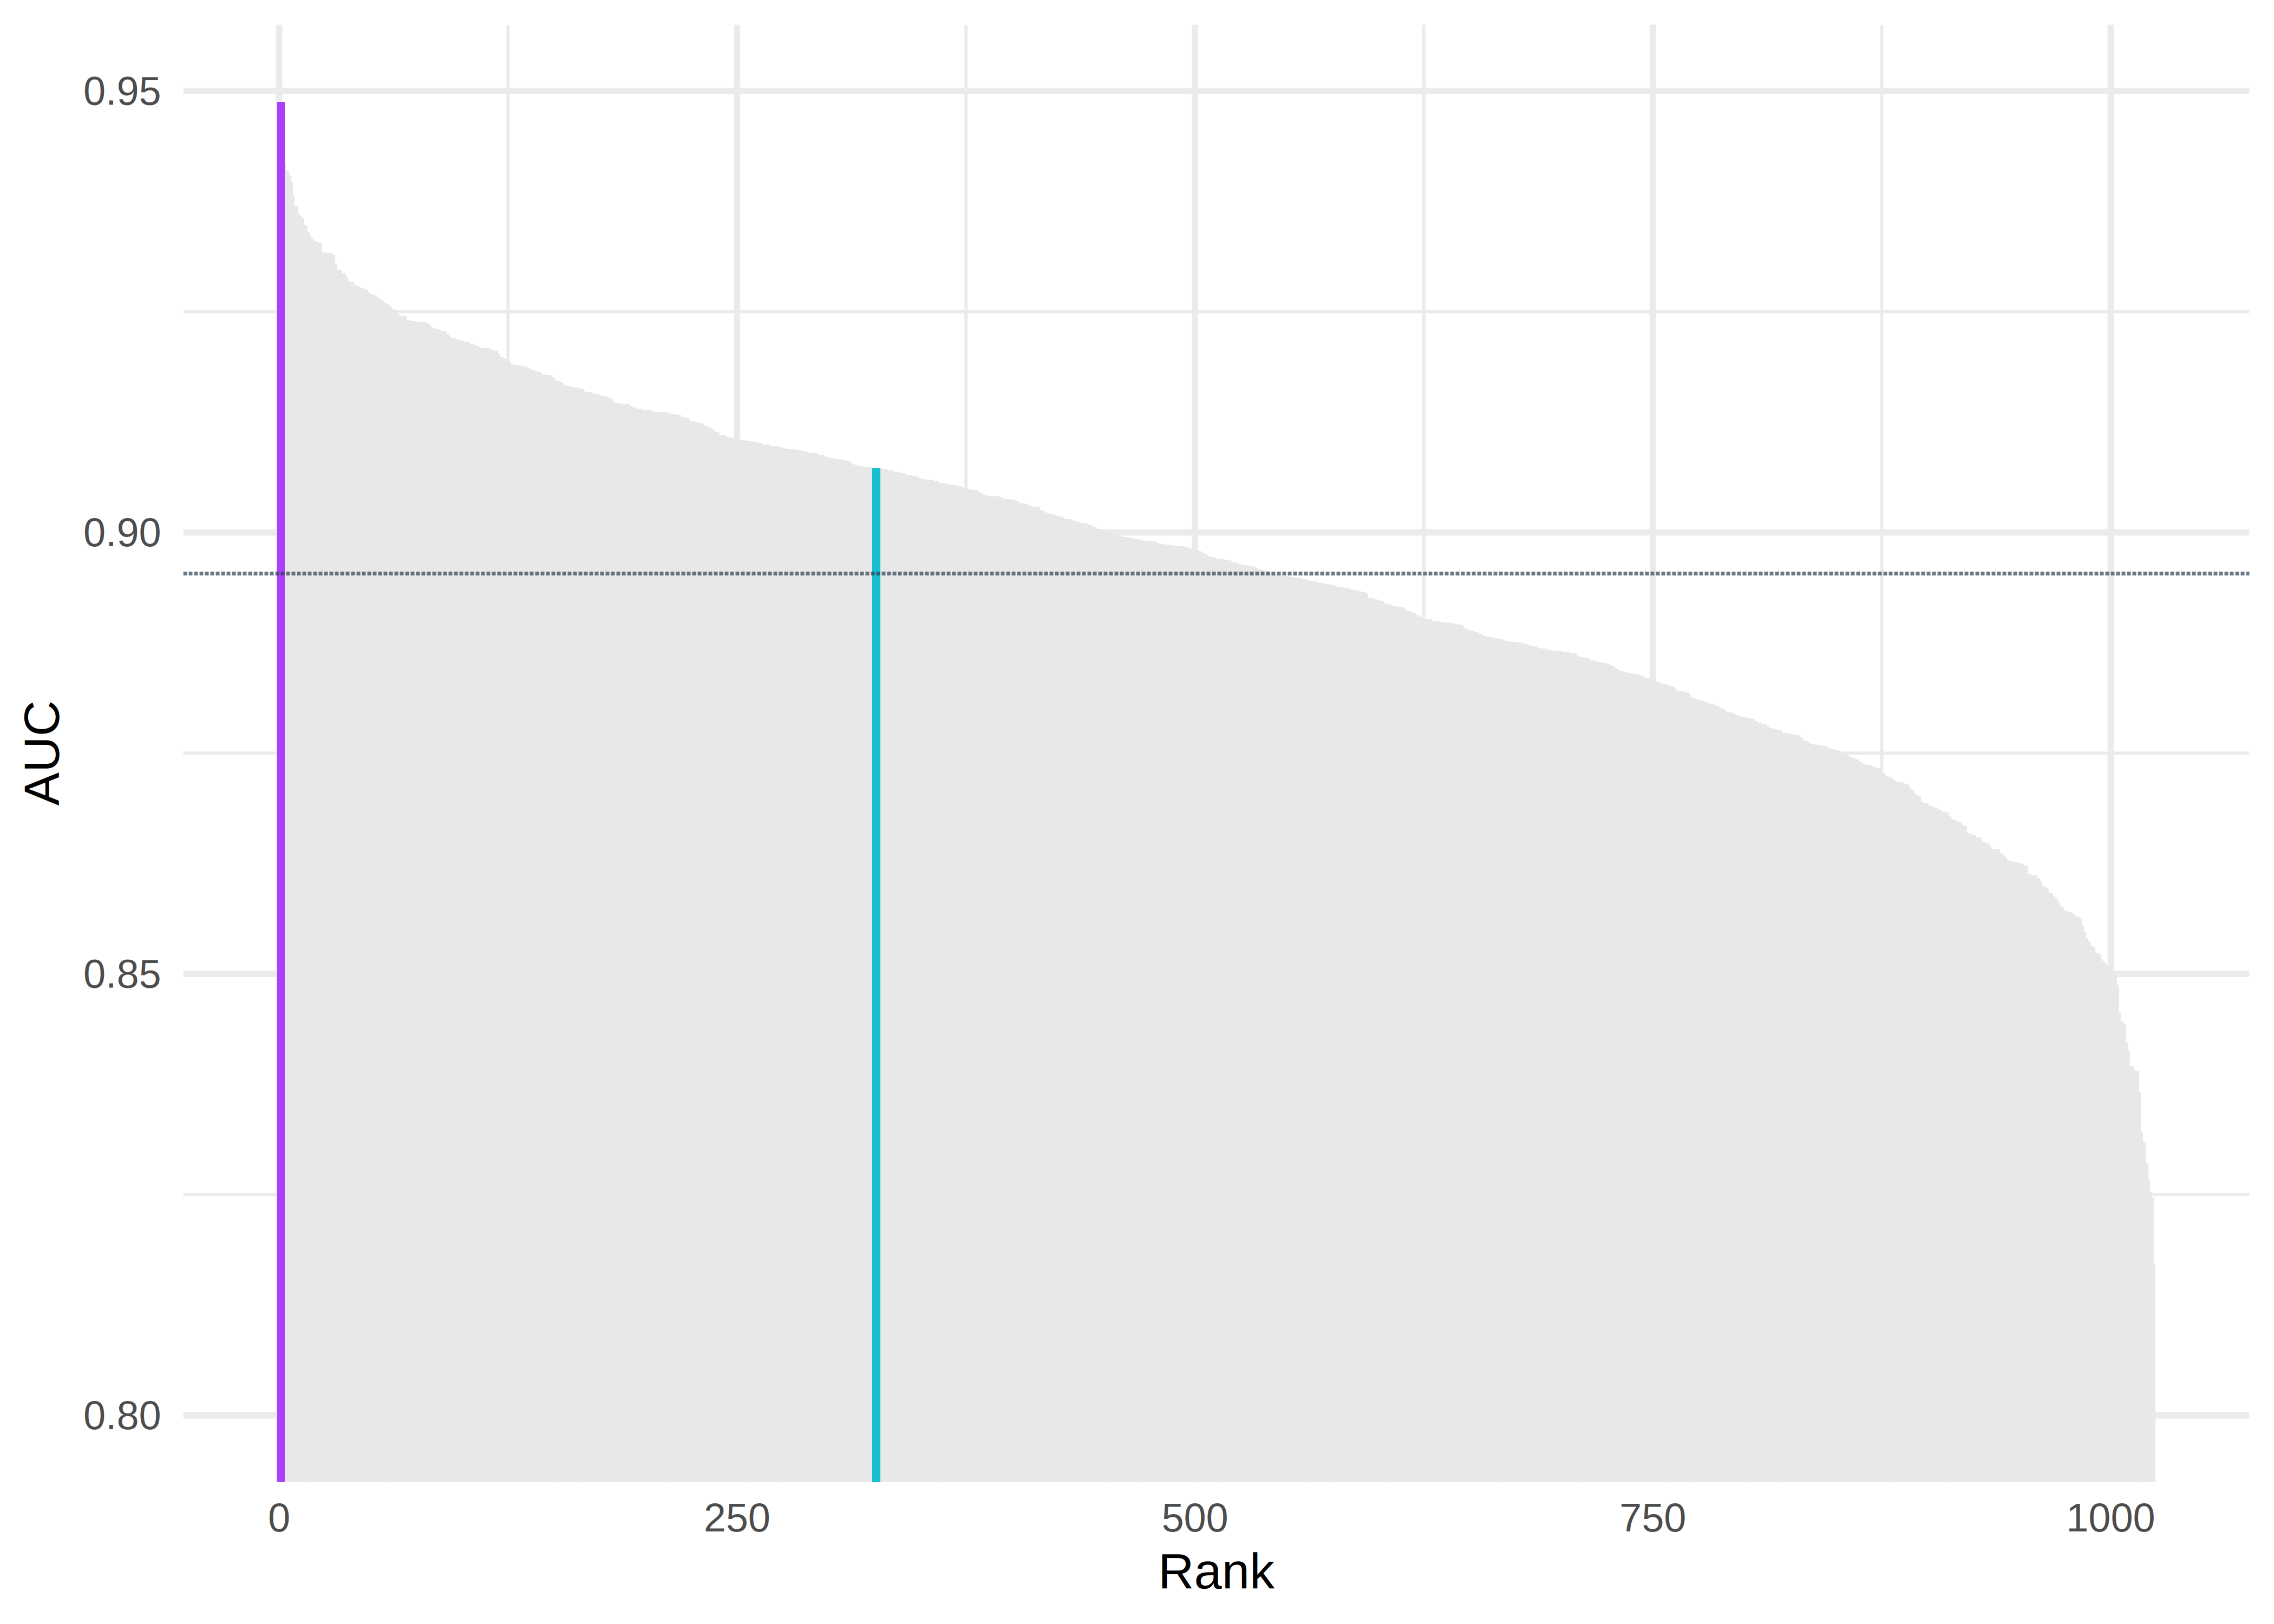

In [77]:
options(repr.plot.res = 600, repr.plot.width = 7, repr.plot.height = 5
        )

ranking$highlight <- ifelse(ranking$Rank %in% c(1, 326), TRUE, FALSE)

p <- ggplot() +
  geom_bar(data = subset(ranking, !highlight),
           aes(x = Rank, y = AUC),
           stat = "identity",
           fill = "#E8E8E8",
           width = 0.8) +

  # Overlay highlighted bars with larger width and custom color
  geom_bar(data = subset(ranking, highlight),
           aes(x = Rank, y = AUC, fill = factor(Rank)),
           stat = "identity",
           width = 4) +  # wider bars

  geom_hline(yintercept = mean(ranking$AUC), 
             linetype = "longdash", 
             color = "#2C3E50", alpha = 0.7, 
             size = 0.3) +

  scale_fill_manual(values = c("1" = "#AA40FC", "326" = "#17BECF")) +
  coord_cartesian(ylim = c(0.8, 0.95)) + 
  theme_minimal() +
  guides(fill = "none")  # remove legend if not needed



p

ggsave(p, file = "ranked_auroc_purple_20250505.png", width = 7, height = 5, dpi = 600, )